This notebook inspects the frequencies of proper names of WEAT word sets in song lyrics. In addition, we build new sets of proper names from the most frequent ones occurrring in song lyrics.

We collect proper names from https://www.ssa.gov/oact/babynames/limits.html.

In [1]:
import re
import glob
from collections import defaultdict
import json
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
# read weat test
weat = json.load(open("../data/Data_WEAT/weat_attrib_target_same_length.json"))

In [3]:
# reat all child names in US
name_files = glob.glob("../data/names_us_births/yob*.txt")

names_all = []

for file in name_files:
    names_ = open(file, 'rt').read().split("\n")[:-1]
    names_ = [n.split(",") for n in names_ ]
    names_all.extend(names_)
     
names_all = pd.DataFrame(names_all, columns=['name', 'gender', 'counts'])
names_all.counts = names_all.counts.astype(int)
names_all = names_all.groupby(['name', 'gender'])['counts'].sum().reset_index(name='counts')

In [4]:
# take most freq 1K names of male and females
names = pd.concat([names_all[names_all.gender=='M'].sort_values("counts", ascending=False)[:1000],
                    names_all[names_all.gender=='F'].sort_values("counts", ascending=False)[:1000]])

In [5]:
def remove_consecutive_repeated_lines(lyric):
    '''
    Remove consecutive repeated lines across the lyric. 
    
    Preserve the stanza structure.
    '''
    
    lines = lyric.strip().split('\n')
    new_lines = [lines[0]]
    for line in lines[1:]:
        
        if line==new_lines[-1]:
            # it is a repeated line
            continue 
        else:
            new_lines.append(line)
        
    lyric_new = '\n'.join(new_lines)
    return lyric_new


In [6]:
pattern = re.compile(r"\b(?:{})\b".format("|".join(names['name'].unique())))

def get_names(text, pattern):
    
    names_in_text = pattern.findall(text)
    names_in_text = set(names_in_text)
    
    return names_in_text


decades = ['1960', '1970', '1980', '1990', '2000']

name_counts_lyrics_all = defaultdict(int)
name_counts_lyrics_male = defaultdict(int)
name_counts_lyrics_female = defaultdict(int)
lyrics_with_names = []
for decade in decades:
    
    print(f'Processing decade {decade}...')
    
    # load all the lyrics of the decade (only person)
    lyrics_artist = pd.read_json(f"../data/dataset_10_no_duplicates/data_lyrics_person_decades/lyrics_{decade}.json.gz",
                                orient='records', lines=True)
    lyrics_artist = lyrics_artist[['artist_id', 'song_id', 'artist_name', 'lyrics', 'other_artist_info']]
    lyrics_artist.loc[:, 'gender'] = lyrics_artist.other_artist_info.apply(lambda a_info: a_info['gender'])
    lyrics_artist.loc[:, 'artist_type'] = 'Person'
    
    lyrics_df = lyrics_artist.reset_index(drop=True)
    
    lyrics_df['names_in_lyrics'] = lyrics_df.lyrics.progress_apply(lambda txt: get_names(txt, pattern))
    
    for idx, row in lyrics_df.iterrows():
        
        names_in_lyric = row.names_in_lyrics
        gender = row.gender
        
        for n in names_in_lyric:
            name_counts_lyrics_all[n] += 1
            
            if gender=='Male':
                name_counts_lyrics_male[n] += 1
            else:
                name_counts_lyrics_female[n] += 1
            
    lyrics_df = lyrics_df[lyrics_df.names_in_lyrics.apply(lambda ns: len(ns)>0)]
    lyrics_with_names.append(lyrics_df)

lyrics_with_names = pd.concat(lyrics_with_names).reset_index(drop=True)


Processing decade 1960...


  0%|          | 0/18500 [00:00<?, ?it/s]

Processing decade 1970...


  0%|          | 0/25990 [00:00<?, ?it/s]

Processing decade 1980...


  0%|          | 0/25738 [00:00<?, ?it/s]

Processing decade 1990...


  0%|          | 0/56050 [00:00<?, ?it/s]

Processing decade 2000...


  0%|          | 0/111568 [00:00<?, ?it/s]

In [7]:
name_counts = pd.DataFrame([name_counts_lyrics_all, name_counts_lyrics_female, name_counts_lyrics_male]).T
name_counts = name_counts.fillna(0).astype(int)
name_counts.columns = ['count_lyrics_all', 'count_lyrics_female', 'count_lyrics_male']
name_counts.index.name = 'name'
name_counts = name_counts.reset_index()

name_counts = name_counts.merge(names.rename(columns={'counts':'counts_us'}), on='name', how='left')
name_counts.head()

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,gender,counts_us
0,Louis,699,78,621,M,399192
1,Don,35770,10731,25039,M,167129
2,Will,8661,2785,5876,M,45063
3,May,2354,701,1653,F,48610
4,Loretta,99,28,71,F,175610


In [8]:
# function to add column for male and female occurrences of names
def split_male_female_count_cols(rows):
    
    row_male = rows[rows.gender=='M']
    row_female = rows[rows.gender=='F']
    
    #counts = rows.iloc[0].counts
    
    if row_male.shape[0]==1:
        n_male_us = row_male.iloc[0].counts_us
    else:
        n_male_us = 0
        
    if row_female.shape[0]==1:
        n_female_us = row_female.iloc[0].counts_us
    else:
        n_female_us = 0
        
        
    #return {'counts':counts, 'n_male_us':n_male_us, 'n_female_us':n_female_us}
    return (n_male_us, n_female_us)

In [9]:
name_counts = name_counts.groupby(["name", 'count_lyrics_all', 
                                   'count_lyrics_female', 'count_lyrics_male']).apply(lambda rows: 
                                                split_male_female_count_cols(rows)).reset_index(name='nnn')
name_counts['n_male_us'], name_counts['n_female_us'] = zip(*name_counts.nnn)

name_counts = name_counts.drop(columns=['nnn'])
#name_counts = name_counts.sort_values('counts', ascending=False)
name_counts.head()

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
0,Aaliyah,115,32,83,0,94707
1,Aaron,116,7,109,592018,0
2,Abbie,4,0,4,0,21693
3,Abby,14,2,12,0,59459
4,Abel,106,9,97,57407,0


### Compare with names in WEAT

In [10]:
weat_male_names = weat['Male_Female_Career_Family']['Male names']
weat_male_names = [n.title() for n in weat_male_names]
weat_male_names

['John', 'Paul', 'Mike', 'Kevin', 'Steve', 'Greg', 'Jeff', 'Bill']

In [11]:
weat_female_names = weat['Male_Female_Career_Family']['Female names']
weat_female_names = [n.title() for n in weat_female_names]
weat_female_names

['Amy', 'Joan', 'Lisa', 'Sarah', 'Diana', 'Kate', 'Ann', 'Donna']

In [12]:
name_counts[name_counts.name.isin(weat_male_names)]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
183,Bill,988,121,867,160382,0
677,Greg,154,12,142,77627,0
825,Jeff,304,24,280,120058,0
867,John,2446,339,2107,5142243,21715
962,Kevin,180,27,153,1174949,0
1216,Mike,901,70,831,204906,0
1334,Paul,1123,173,950,1391502,0
1566,Steve,492,54,438,240698,0


In [13]:
name_counts[name_counts.name.isin(weat_female_names)]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
83,Amy,110,28,82,0,694590
102,Ann,195,32,163,0,469118
457,Diana,115,30,85,0,361882
474,Donna,140,32,108,0,831114
853,Joan,130,41,89,0,480325
925,Kate,109,30,79,0,82741
1057,Lisa,337,69,268,0,965824
1493,Sarah,205,61,144,0,1084272


In [14]:
weat_euro_names = weat['EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant']['European American names']
weat_euro_names = [n.title() for n in weat_euro_names]
weat_euro_names

['Harry',
 'Amber',
 'Heather',
 'Adam',
 'Frank',
 'Chip',
 'Peter',
 'Paul',
 'Crystal',
 'Jack']

In [15]:
weat_afric_names = weat['EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant']['African American names']
weat_afric_names = [n.title() for n in weat_afric_names]
weat_afric_names

['Theo',
 'Jerome',
 'Leroy',
 'Tyrone',
 'Ebony',
 'Jasmine',
 'Tia',
 'Latoya',
 'Yolanda',
 'Yvette']

In [16]:
name_counts[name_counts.name.isin(weat_euro_names)]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
10,Adam,456,78,378,562522,0
78,Amber,50,18,32,0,371853
375,Crystal,227,32,195,0,330969
617,Frank,567,56,511,912710,0
710,Harry,290,45,245,422126,0
717,Heather,68,23,45,0,525048
773,Jack,1627,282,1345,712342,0
1334,Paul,1123,173,950,1391502,0
1348,Peter,637,118,519,580391,0


In [17]:
name_counts[name_counts.name.isin(weat_afric_names)]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
499,Ebony,45,13,32,0,38866
809,Jasmine,36,5,31,0,250458
838,Jerome,79,12,67,160367,0
1007,Latoya,15,0,15,0,45524
1037,Leroy,54,7,47,199572,0
1607,Theo,19,2,17,17236,0
1614,Tia,11,2,9,0,33215
1657,Tyrone,30,4,26,78747,0
1719,Yolanda,27,7,20,0,112622
1720,Yvette,16,3,13,0,63424


In [18]:
weat_euro_names = weat['EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant_2']['European American names']
weat_euro_names = [n.title() for n in weat_euro_names]
weat_euro_names

['Greg', 'Neil', 'Emily', 'Anne', 'Jill', 'Sarah', 'Jay']

In [19]:
weat_euro_names = weat['EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant_2']['African American names']
weat_euro_names = [n.title() for n in weat_euro_names]
weat_euro_names

['Jermaine', 'Leroy', 'Tyrone', 'Ebony', 'Keisha', 'Kenya', 'Latoya']

In [20]:
name_counts[name_counts.name.isin(weat_euro_names)]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
499,Ebony,45,13,32,0,38866
837,Jermaine,119,12,107,41303,0
941,Keisha,54,7,47,0,21996
957,Kenya,26,4,22,0,24746
1007,Latoya,15,0,15,0,45524
1037,Leroy,54,7,47,199572,0
1657,Tyrone,30,4,26,78747,0


In [21]:
name_counts[name_counts.name.isin(weat_afric_names)]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
499,Ebony,45,13,32,0,38866
809,Jasmine,36,5,31,0,250458
838,Jerome,79,12,67,160367,0
1007,Latoya,15,0,15,0,45524
1037,Leroy,54,7,47,199572,0
1607,Theo,19,2,17,17236,0
1614,Tia,11,2,9,0,33215
1657,Tyrone,30,4,26,78747,0
1719,Yolanda,27,7,20,0,112622
1720,Yvette,16,3,13,0,63424


African names are very rare, so we will not perform this test.

### Search most freq names in lyrics

In [22]:
# most freq male names in all corpus
name_counts[name_counts.n_female_us<name_counts.n_male_us].sort_values('count_lyrics_all', 
                                                                       ascending=False)[:50]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
472,Don,35770,10731,25039,167129,0
1704,Will,8661,2785,5876,45063,0
844,Jesus,5601,1352,4249,233224,0
971,King,3671,675,2996,30956,0
867,John,2446,339,2107,5142243,21715
862,Joe,1797,257,1540,451868,0
773,Jack,1627,282,1345,712342,0
871,Johnny,1259,218,1041,314215,0
788,James,1142,178,964,5190161,23528
1334,Paul,1123,173,950,1391502,0


In [23]:
# most freq female names in all corpus
name_counts[name_counts.n_female_us>name_counts.n_male_us].sort_values('count_lyrics_all', 
                                                                       ascending=False)[:50]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
718,Heaven,3067,859,2208,0,27234
1190,May,2354,701,1653,0,48610
1170,Mary,1969,534,1435,15172,4130314
736,Hope,1628,472,1156,0,91695
1063,London,1143,179,964,0,39365
228,Brooklyn,981,115,866,0,110575
1571,Summer,907,275,632,0,81385
1325,Paris,841,243,598,0,30500
907,June,813,228,585,0,196494
649,Georgia,732,113,619,0,155458


In [24]:
# most freq male names in female corpus
name_counts[name_counts.n_female_us<name_counts.n_male_us].sort_values('count_lyrics_female', 
                                                                       ascending=False)[:50]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
472,Don,35770,10731,25039,167129,0
1704,Will,8661,2785,5876,45063,0
844,Jesus,5601,1352,4249,233224,0
971,King,3671,675,2996,30956,0
867,John,2446,339,2107,5142243,21715
773,Jack,1627,282,1345,712342,0
862,Joe,1797,257,1540,451868,0
871,Johnny,1259,218,1041,314215,0
788,James,1142,178,964,5190161,23528
414,David,1032,174,858,3638877,0


In [25]:
# most freq male names in male corpus
name_counts[name_counts.n_female_us<name_counts.n_male_us].sort_values('count_lyrics_male', 
                                                                       ascending=False)[:50]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
472,Don,35770,10731,25039,167129,0
1704,Will,8661,2785,5876,45063,0
844,Jesus,5601,1352,4249,233224,0
971,King,3671,675,2996,30956,0
867,John,2446,339,2107,5142243,21715
862,Joe,1797,257,1540,451868,0
773,Jack,1627,282,1345,712342,0
871,Johnny,1259,218,1041,314215,0
788,James,1142,178,964,5190161,23528
1334,Paul,1123,173,950,1391502,0


In [26]:
# most freq female names in male corpus
name_counts[name_counts.n_female_us>name_counts.n_male_us].sort_values('count_lyrics_male', 
                                                                       ascending=False)[:50]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
718,Heaven,3067,859,2208,0,27234
1190,May,2354,701,1653,0,48610
1170,Mary,1969,534,1435,15172,4130314
736,Hope,1628,472,1156,0,91695
1063,London,1143,179,964,0,39365
228,Brooklyn,981,115,866,0,110575
1571,Summer,907,275,632,0,81385
649,Georgia,732,113,619,0,155458
1325,Paris,841,243,598,0,30500
907,June,813,228,585,0,196494


In [27]:
# most freq female names in female corpus
name_counts[name_counts.n_female_us>name_counts.n_male_us].sort_values('count_lyrics_female', 
                                                                       ascending=False)[:50]

,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us
718,Heaven,3067,859,2208,0,27234
1190,May,2354,701,1653,0,48610
1170,Mary,1969,534,1435,15172,4130314
736,Hope,1628,472,1156,0,91695
1571,Summer,907,275,632,0,81385
1325,Paris,841,243,598,0,30500
907,June,813,228,585,0,196494
585,Eve,701,207,494,0,26687
1063,London,1143,179,964,0,39365
114,April,551,160,391,0,239950


In [28]:
# these nouns were selected by taking 50 the most frequent in song lyrics
# for which the n_male_us is higher then n_female_us (for male names) and
# the n_female_us is higher then n_male_us (for female names) 
# we discarded proper nouns that may be confused with common nouns (e.g., Don, Will, King) or
# related to religion (e.g., Jesus, Angel)

# as a refinement, we added also most freq female and male names among the most freq in the female corpus 
# and most freq male and female names among the most freq male corpus

# when taking one name, we need also to ensure it occurs in both male and female lyrics

new_male_names = ['John', 'Jack', 'Joe', 'Johnny', 'James', 'David', 'Paul', 'Billy', 'Jimmy',
                 'Simon', 'Mark', 'Romeo', 'Bill', 'Peter', 'Bob', 'Lee', 'Jim', 'Bobby', 'Tom', 'Jackson',
                 'Sam', 'Michael', 'Charlie', 'Adam']


new_female_names = ['Kim', 'Rose', 'Mary', 'Eve', 'Kelly', 'Jane', 'Lisa', 'Juliet', 'Jean', 'Annie', 'Trina',
                   'Sarah', 'Sally', 'Betty', 'Lucy', 'Taylor', 'Bonnie', 'Marie', 'Jenny', 'Dolly', 'Julia',
                   'Anna', 'Jill', 'Angie']

### Check occurrence of new names in syrics

In [29]:
# the min freq of nouns in male and female corpors is 42 and 49
name_counts[name_counts.name.isin(new_male_names+new_female_names)].min()

name                   Adam
count_lyrics_all         96
count_lyrics_female      49
count_lyrics_male        42
n_male_us                 0
n_female_us               0
dtype: object

### Save the lists

In [30]:
# save new list of names
with open('../data/Data_WEAT/new_male_names.txt', 'wt') as ww:
    for name in new_male_names:
        ww.write(name+'\n')
        
with open('../data/Data_WEAT/new_female_names.txt', 'wt') as ww:
    for name in new_female_names:
        ww.write(name+'\n')

In [31]:
# save the count of names
name_counts.to_csv("../results/proper_names_counts.csv", index=False)

In [32]:
lyrics_with_names.to_json("../results/lyrics_with_prroper_names.json.gz", orient='records', lines=True,
                         compression='gzip')

Are these names androgynous?

In [33]:
name_counts_new = name_counts[name_counts.name.isin(new_male_names+new_female_names)]

name_counts_new['name_masculinity'] = name_counts_new.apply(lambda row: 
                                 row.n_male_us/(row.n_female_us+row.n_male_us), axis=1)

name_counts_new

/var/folders/kk/x6qrg2692871zn230xsl78300000gn/T/ipykernel_1310/4207254855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_counts_new['name_masculinity'] = name_counts_new.apply(lambda row:


,name,count_lyrics_all,count_lyrics_female,count_lyrics_male,n_male_us,n_female_us,name_masculinity
10,Adam,456,78,378,562522,0,1.000000
100,Angie,113,49,64,0,63567,0.000000
103,Anna,175,52,123,0,900284,0.000000
107,Annie,210,65,145,0,352700,0.000000
178,Betty,325,59,266,0,1000106,0.000000
183,Bill,988,121,867,160382,0,1.000000
185,Billy,944,166,778,383165,0,1.000000
191,Bob,848,111,737,92958,0,1.000000
194,Bobby,817,101,716,314037,0,1.000000
196,Bonnie,217,57,160,0,325360,0.000000


<AxesSubplot:ylabel='Frequency'>

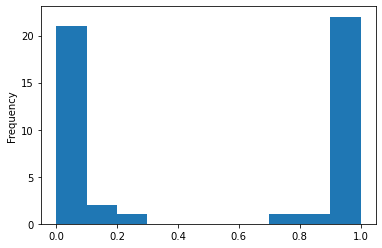

In [34]:
name_counts_new.name_masculinity.plot(kind='hist')